In [67]:
%matplotlib inline

In [2]:
%cd
%cd nbs/fastai/
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.sgdr import *
from fastai.plots import *

from fastai.transforms import *

/home/ubuntu
/home/ubuntu/nbs/fastai


# Data Setup

In [3]:
%cd 
%cd nbs/
DataPath = 'data/planetamazon/'

/home/ubuntu
/home/ubuntu/nbs


In [4]:
bs = 64

Metrics on which competition are based on. We'll also be using a resnet 34 model.

In [5]:
from sklearn.metrics import fbeta_score
import warnings

arch = resnet34
def f2(preds, targs, start = 0.17, end = 0.24, step = 0.01):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        return max([fbeta_score(targs, (preds > th), 2, average = 'samples')
                   for th in np.arange(start, end, step)])
metrics = [f2]

Function to create cross-validation set

In [6]:
def get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42):
    np.random.seed(seed)
    n_val = int(val_pct*n)
    idx_start = cv_idx*n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start+n_val]

In [7]:
label_csv = f'{DataPath}train_v2.csv'
n = len(list(open(label_csv))) - 1
#Creates cross-validation set
val_idxs = get_cv_idxs(n)

In [23]:
n

40479

In [19]:
len(label_csv)

30

In [20]:
len(val_idxs)

8095

Function to augment and retrieve data from jpg and csv files.

In [8]:
def get_data(sz):
    tfms = tfms_from_model(arch, sz, aug_tfms = transforms_top_down, max_zoom = 1.05)
    return ImageClassifierData.from_csv(DataPath, 'train-jpg', label_csv, tfms = tfms,
                                       suffix = '.jpg', val_idxs = val_idxs, test_name = 'test-jpg')
    

Uses the augmented data retrieved from the get_data() function to increase pixel dimension count, and to further train / fine-tune the last layers of the same classifier. 

In [9]:
def set_data(self, data, precompute=False):
        super().set_data(data)
        if precompute:
            self.unfreeze()
            self.save_fc1()
            self.freeze()
            self.precompute = True
        else:
            self.freeze()

In [47]:
data = get_data(sz = 256)

In [48]:
x, y = next(iter(data.val_dl))

In [49]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.FloatTensor of size 64x17]

In [50]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

Image size at 256 by 256 pixels.

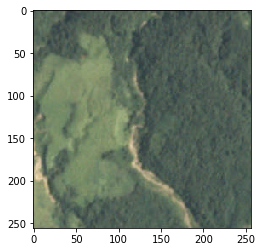

In [51]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4)

Changed image size to 64 so that training is faster, and to reduce overfitting. We'll also train this model through increasing the pixel account the further we train it to help fine-tune the last layers of our model.

In [53]:
x, y = next(iter(data.val_dl))

Can compare pixel images of 256 img vs 64 img. We start the model with the 64 pixel size image to help the model slowly tune to the features present in these images.

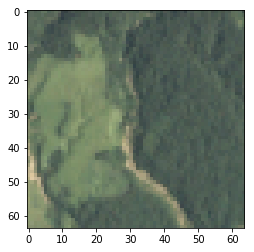

In [54]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4)

# Exploratory Data Analysis

In [32]:
data = get_data(sz = 256)

In [34]:
labels_df = pd.read_csv(DataPath + 'train_v2.csv')

In [35]:
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Lists all unique features.

In [39]:
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
labels_set = set(labels_list)
labels_set

{'agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water'}

In [81]:
from glob import glob
image_paths = sorted(glob(DataPath + 'train-jpg/*.jpg'))[0:1000]
image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))
image_names[0:10]

['train_0',
 'train_1',
 'train_10',
 'train_100',
 'train_1000',
 'train_10000',
 'train_10001',
 'train_10002',
 'train_10003',
 'train_10004']

In [82]:
import cv2

n_imgs = 600

all_imgs = []

for i in range(n_imgs):
    img = plt.imread(image_paths[i])
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype('float')
#    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype('float')
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    all_imgs.append(img)

img_set = np.vstack(all_imgs)
img_set.shape

(600, 40000)

### Histogram of Unique Labels

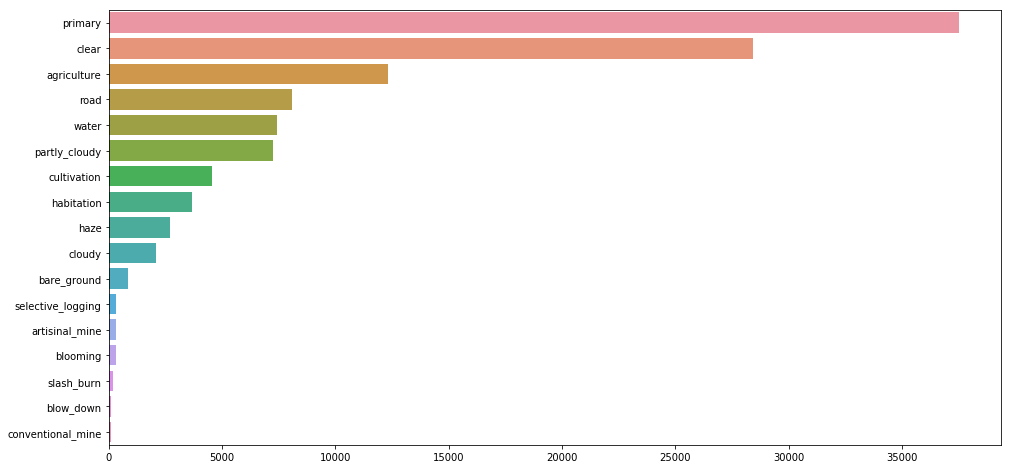

In [50]:
labels_unique = pd.Series(labels_list).value_counts()
fig, ax = plt.subplots(figsize = (16,8))
sns.barplot(x = labels_unique, y = labels_unique.index, orient = 'h')

### List of Images From Each Class

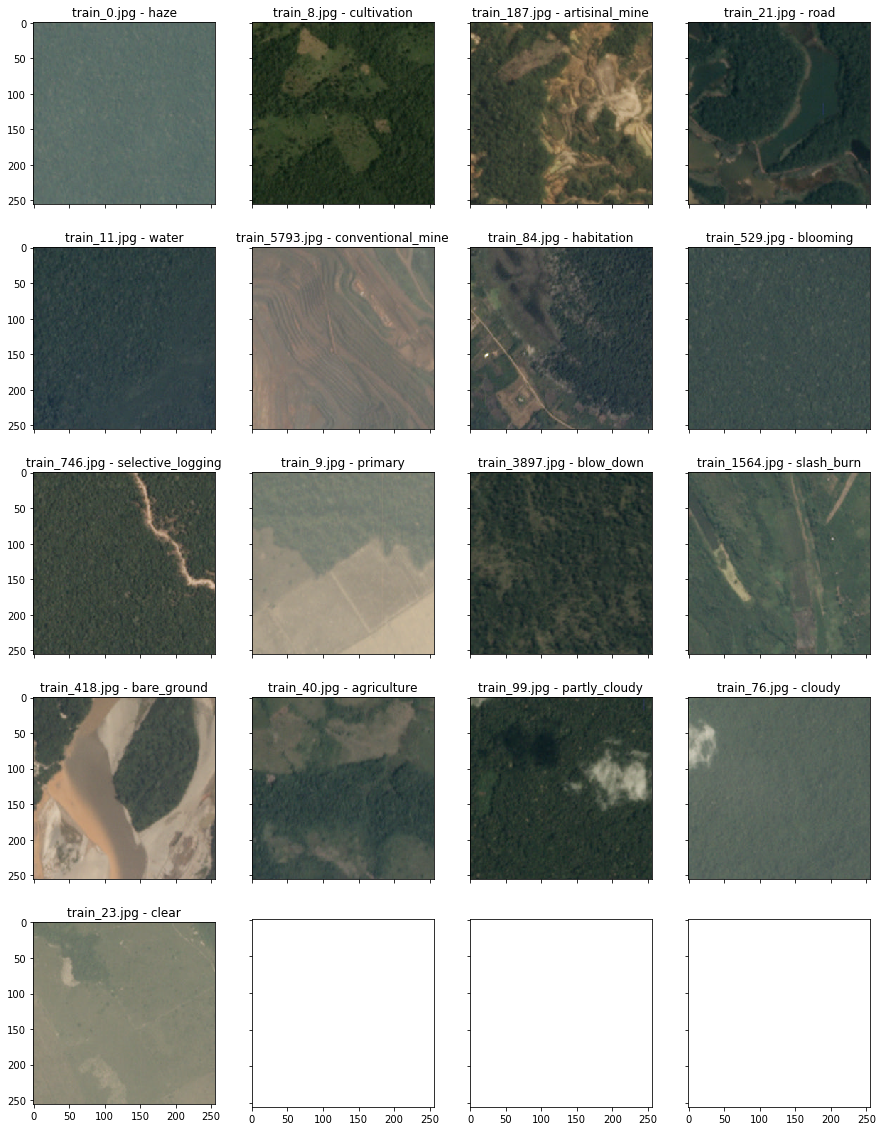

In [55]:
images_title = [labels_df[labels_df['tags'].str.contains(label)].iloc[i]['image_name'] 
                + '.jpg' for i, label in enumerate(labels_set)]

plt.rc('axes', grid = False)
_, axs = plt.subplots(5, 4, sharex = 'col', sharey = 'row', figsize = (15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = plt.imread(DataPath + 'train-jpg/' + image_name)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))

### Image Scatter Plot

A 2D scatter plot based off of image attributes (PCA)

In [96]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
).fit_transform(img_set)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.529s...
[t-SNE] Computed neighbors for 600 samples in 28.148s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 2.026685
[t-SNE] Computed conditional probabilities in 0.041s
[t-SNE] Iteration 50: error = 78.0383987, gradient norm = 0.4217582 (50 iterations in 0.711s)
[t-SNE] Iteration 100: error = 83.7400284, gradient norm = 0.3507283 (50 iterations in 0.727s)
[t-SNE] Iteration 150: error = 85.3227844, gradient norm = 0.3523475 (50 iterations in 0.679s)
[t-SNE] Iteration 200: error = 85.4697037, gradient norm = 0.3344637 (50 iterations in 0.678s)
[t-SNE] Iteration 250: error = 83.3442535, gradient norm = 0.3768646 (50 iterations in 0.684s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.344254
[t-SNE] Iteration 300: error = 1.3565561, gradient norm = 0.0043714 (50 iterations in 0.641s)
[t-SNE] Iteration 350: error = 0.9711857, gradient norm = 0.0046703 

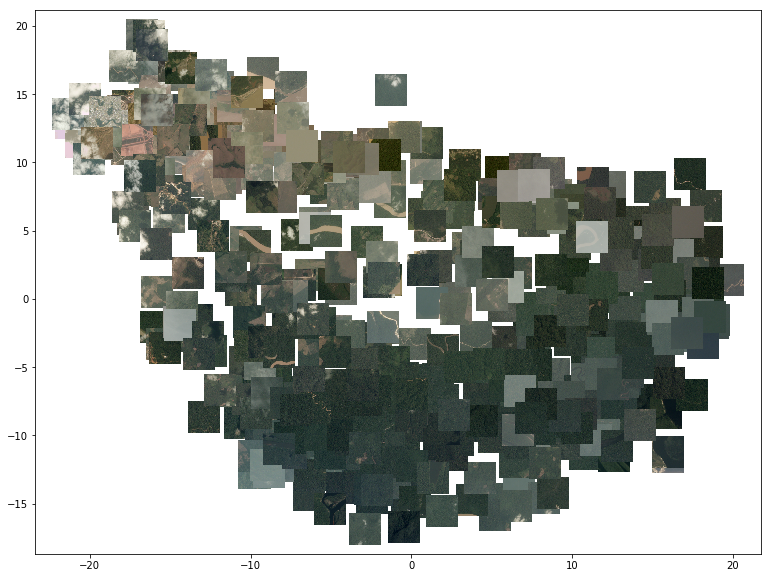

In [105]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def imscatter(x, y, images, ax=None, zoom=0.125):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    #return artists

nimgs = 500
plt.figure(figsize=(13,10))
imscatter(tsne[0:nimgs,0], tsne[0:nimgs,1], [plt.imread(image_paths[i]) for i in range(nimgs)])

### 3D Embedding of Images

A 3D scatter plot based off of image attributes (PCA)

In [90]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [91]:
tsneEmb = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
).fit_transform(img_set)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.523s...
[t-SNE] Computed neighbors for 600 samples in 27.940s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 2.026685
[t-SNE] Computed conditional probabilities in 0.039s
[t-SNE] Iteration 50: error = 97.9050217, gradient norm = 0.2330765 (50 iterations in 1.710s)
[t-SNE] Iteration 100: error = 112.9229965, gradient norm = 0.1681537 (50 iterations in 1.647s)
[t-SNE] Iteration 150: error = 118.4972000, gradient norm = 0.1550066 (50 iterations in 1.593s)
[t-SNE] Iteration 200: error = 123.3423386, gradient norm = 0.1496353 (50 iterations in 1.656s)
[t-SNE] Iteration 250: error = 126.5430984, gradient norm = 0.1241635 (50 iterations in 1.590s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 126.543098
[t-SNE] Iteration 300: error = 4.3612361, gradient norm = 0.0006650 (50 iterations in 1.849s)
[t-SNE] Iteration 350: error = 3.7498093, gradient norm = 0.000

In [92]:
trace1 = go.Scatter3d(
    x=tsneEmb[:,0],
    y=tsneEmb[:,1],
    z=tsneEmb[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        #color = preprocessing.LabelEncoder().fit_transform(all_image_types),
        #colorscale = 'Portland',
        #colorbar = dict(title = 'images'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.9
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3D embedding of images')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

# ResNet Model

In [15]:
sz = 64

In [13]:
data = get_data(sz)

In [16]:
learn = ConvLearner.pretrained(arch, data, metrics = metrics, precompute = False)

Finding the optimal learning rate to choose.

In [74]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2         
    0      0.215787   0.252579   0.830287  



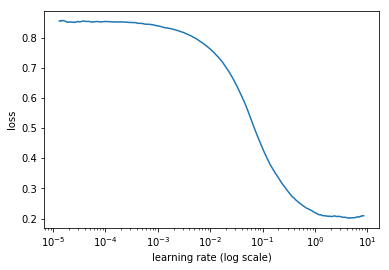

In [76]:
learn.sched.plot()

Learning rate seems to be most optimal around 10^-1.

In [20]:
lr = .2

In [21]:
lrs = np.array([lr/9, lr/3, lr])

In [82]:
learn.fit(lr, 2, cycle_len = 1, cycle_mult = 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   f2         
    0      0.146557   0.133245   0.882298  
    1      0.138776   0.127599   0.890007  
    2      0.137035   0.125078   0.890474  



[0.12507835, 0.8904740428044584]

In [24]:
learn.unfreeze()

In [27]:
learn.fit(lrs, 2, cycle_len = 1, cycle_mult = 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   f2         
    0      0.11911    0.105173   0.909907  
    1      0.114208   0.101447   0.916441  
    2      0.102888   0.097851   0.917274  



[0.09785125, 0.9172741204630667]

Training epoch time of about 21 minutes.

In [28]:
learn.save(f'{sz}')

In [17]:
learn.load(f'{sz}')

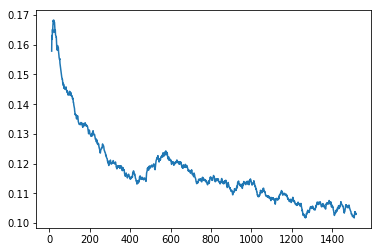

In [30]:
learn.sched.plot_loss()

Now we train our classifier on images with higher resolution of 128 by 128 (higher pixels).

In [18]:
sz = 128

In [34]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 1, cycle_len = 1, cycle_mult = 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2         
    0      0.100352   0.097305   0.915745  



[0.09730466, 0.9157454677424791]

In [22]:
learn.unfreeze()
learn.fit(lrs, 1, cycle_len = 1, cycle_mult = 1)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2         
    0      0.098294   0.090394   0.924811  



Training epoch time of about 57 minutes.

Test Time Accuracy

In [29]:
multi_preds, y = learn.TTA()

In [30]:
preds = np.mean(multi_preds, 0)

In [31]:
f2(preds, y)

0.925752913625778